<a href="https://colab.research.google.com/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_sessions_within_subject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-Sessions Within Subject Testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we’ll explore how to perform across-sessions within-subject testing using the [GLHMM toolbox](https://github.com/vidaurre/glhmm), based on the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is ideal for studying within-subject variability across multiple sessions, making it especially useful for longitudinal studies.

To focus on the statistical testing, we use **synthetic data** generated using the [Genephys toolbox](https://github.com/vidaurre/genephys) by [Vidaurre (2023)](https://elifesciences.org/reviewed-preprints/87729). Genephys simulates EEG or MEG data in psychometric experiments, where a subject is repeatedly exposed to stimuli, 

For this tutorial:

- $D$: Gamma values — the decoded state probabilities from an HMM. These were computed from synthetic EEG/MEG-like data across 1500 trials (250 timepoints per trial), grouped into 10 sessions.
- $R$: categorical labels representing the stimulus shown on each trial (e.g., animate vs inanimate objects).

> **Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_sessions_within_subject.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Preparation](#preparation)
2. [Load data](#load-data)
    * [Data restructuring](#data-recon)
3. [Across-sessions within subject testing](#across_sessions)
    * [Across-sessions within subject testing - Multivariate](#perm-regression)
    * [Across-sessions within subject testing - Univariate](#perm-correlation)

# **1. Preparation** <a id="preparation"></a>

If you don't have the **GLHMM package** installed, this notebook will help you install it automatically.

We will also download example data from the Open Science Framework (OSF).

---


In [2]:
# Install required packages
import sys
import subprocess
from pathlib import Path

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install GLHMM if using Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Detected Google Colab. Installing GLHMM...")
    install("git+https://github.com/vidaurre/glhmm")

# Install osfclient if missing
try:
    import osfclient
except ImportError:
    print("Installing osfclient...")
    install("osfclient")

# Import libraries
import numpy as np
from glhmm import graphics, statistics


# **2. Load data** <a id="load-data"></a>
To get started, we’ll download the synthetic data needed use it to run the across-sessions test.
If they already exist, we will skip downloading.

We’ll use the `osfclient` package to fetch the files directly from the Open Science Framework (OSF). If you prefer, you can also download them manually from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

In [4]:
# Set up data directory
data_dir = Path.cwd() / "files" / "data_statistical_testing"

if not data_dir.exists():
    print(f"Creating {data_dir}...")
    data_dir.mkdir(parents=True, exist_ok=True)
else:
    print(f"Data directory {data_dir} already exists.")

# Files to download
files = [
    "Gamma_sessions.npy",
    "R_sessions.npy",
    "idx_sessions.npy",
]

# Download the files from OSF if they don't exist locally
for fname in files:
    local_path = data_dir / fname
    remote_path = f"data_statistical_testing/{fname}"

    if local_path.exists():
        print(f"✓ {fname} already exists — skipping.")
    else:
        print(f"Downloading {fname}...")
        # as_posix() ensures forward slashes on Windows for shell compatibility
        !osf -p 8qcyj fetch {remote_path} {local_path.as_posix()}


Data directory c:\Users\au323479\Github\glhmm\docs\notebooks\files\data_statistical_testing already exists.
✓ Gamma_sessions.npy already exists — skipping.
✓ R_sessions.npy already exists — skipping.
✓ idx_sessions.npy already exists — skipping.


**Load and check the data**\
The folder `data_statistical_testing` contains:

- **`Gamma_sessions`**: decoded HMM state probabilities (Gamma values)  
  Shape **(n_timepoints × n_trials, n_states)** : **375,000 × 6** — where 375,000 = 250 timepoints × 1500 trials  
  Each row is a timepoint; each column corresponds to one of 6 HMM states

- **`R_sessions`**: stimulus condition label for each trial (0 or 1)  
  Shape **(n_trials,)**: 1D array with one value for each of 1500 trials

- **`idx_sessions`**: session boundaries  
  Shape **(n_sessions, 2)**: 2D array with 10 rows — each row defines the start and end index for a session

> **Note**: For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](./GLHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). In this notebook, we use precomputed Gamma values to focus on the across-sessions statistical test.

Let’s load the files into memory:

In [7]:
# Define the data folder path
PATH_PARENT = Path.cwd()
PATH_DATA = PATH_PARENT / "files" / "data_statistical_testing"

# Load brain and behavioral data
Gamma_sessions = np.load(PATH_DATA / "Gamma_sessions.npy")
R_sessions = np.load(PATH_DATA / "R_sessions.npy")
idx_sessions = np.load(PATH_DATA / "idx_sessions.npy")

Check data dimensions

In [8]:
print("Gamma_sessions shape:", Gamma_sessions.shape)  # (375000, 6)
print("R_sessions shape:", R_sessions.shape)     # (1500,)
print("idx_sessions shape:", idx_sessions.shape) # (10, 2)


Gamma_sessions shape: (375000, 6)
R_sessions shape: (1500,)
idx_sessions shape: (10, 2)


### **Data restructuring** <a id="data-recon"></a>
Now that we have our decoded Gamma values, we need to reshape the data back into a trial-wise format. This step is essential because we will run statistical tests at each time point, rather than using HMM-aggregated features like fractional occupancy.

To do this, we’ll use the function `reconstruct_concatenated_to_3D`. It converts a concatenated 2D array into a structured 3D array — restoring the original format of `(timepoints × trials × features)`.


**Convert Gamma to trial-wise format**

In [4]:
# Define the dimensions
n_timepoints = 250
n_trials = 1500
n_features = Gamma_sessions.shape[1]

# Reshape Gamma into a 3D array: timepoints × trials × features
Gamma_epoch = statistics.reconstruct_concatenated_to_3D(
    Gamma_sessions,
    n_timepoints=n_timepoints,
    n_entities=n_trials,
    n_features=n_features
)

# Check the new shape
print("Gamma_epoch shape:", Gamma_epoch.shape)  # Expected: (250, 1500, 6)


Gamma_epoch shape: (250, 1500, 6)


**Sanity check: does the reshaping work?**

To confirm the data was reshaped correctly, let’s compare a slice of the new 3D matrix with the original 2D version.

We’ll compare:

`Gamma_epoch[:, 0, :]`: all timepoints from the first trial in the reshaped 3D matrix

`Gamma_sessions[0:250, :]`: the first 250 timepoints in the original 2D matrix

In [5]:
np.array_equal(Gamma_epoch[:, 0, :], Gamma_sessions[0:250, :])

True

If this returns True, the reshaping was successful — every timepoint from the first trial is correctly aligned in the new format.



# **3. Across-sessions within subject testing** <a id="across_sessions"></a>

Now that our data is reshaped into sessions and trials, we're ready to test whether changes in brain activity (Gamma) are related to behavioral variation across sessions using the `test_across_sessions_within_subject` function.

Before we dive into the test, let’s quickly explain what’s going on.

In this type of test, we want to find out if the brain behaves differently depending on the type of stimulus shown — and whether this difference changes from session to session. For example, does the brain respond to inanimate objects the same way every time? Or does something shift over multiple sessions?

To answer that, we use **permutation testing**. This means we shuffle session labels to see what kind of results we’d expect just by chance. If the patterns we observe in the original (unshuffled) data differ substantially from those in the shuffled data,it suggests that the brain activity is systematically influenced across the different sessions.


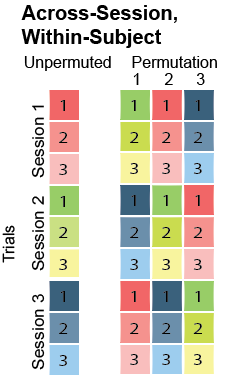

 **Figure 5C** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across sessions. Each number corresponds to a trial within a session and permutations are performed between sessions, with each session containing the same number of trials.



## **Across-sessions within subject testing - Multivariate**<a id="perm-regression"></a>

We’ll start by running a **multivariate test**. This checks whether patterns of brain state activity can explain differences in the stimulus condition (like animate vs inanimate) across sessions.

If brain responses are stable over time, we won’t find much. But if they vary in a way that matches the stimuli, that tells us something interesting is happening.

#### Inputs:
- `D_data`: the Gamma matrix reshaped into trials (`Gamma_epoch`)
- `R_data`: stimulus labels for each trial (`R_sessions`, values 0 or 1)
- `indices_blocks`: trial indices for each session (`idx_sessions`)

#### Settings:
- `method = "multivariate"`: perform multivariate regression
- `Nnull_samples = 10_000`: number of permutations to build the null distribution



In [ ]:
# Set the parameters for across sessions within subject testing
method = "multivariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)

# Perform across-subject testing
result_multivariate_session  =statistics.test_across_sessions_within_subject(D_data=Gamma_epoch, 
                                                                             R_data=R_sessions, 
                                                                             indices_blocks=idx_sessions,
                                                                             method=method,
                                                                             Nnull_samples=Nnull_samples)

Total possible permutations: 3.62e+6
Running number of permutations: 10000
performing permutation testing per timepoint


100%|██████████| 250/250 [26:21<00:00,  6.32s/it]


In [22]:
import math
math.factorial(7) 

5040

**Understanding the output**

The result is stored in a dictionary called `result_multivariate`. Here's what it contains:

* ```pval```: array of p-values with shape (1, q). Each value corresponds to a behavioral variable. See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details.

* ```base_statistics```: test statistics for the unpermuted data. For multivariate tests, this is the F-statistic

* ```null_stat_distribution```: array of test statistics computed from each permutation

* ```statistical_measures```: dictionary showing which statistic was used (e.g. F-stat)

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_trials```.

* ```method```:  test method used, here it is `"multivariate"`

* ```max_correction```: whether MaxT correction was applied during permutation

* ```Nnull_samples```: number of permutations used to generate the null

* ```test_summary```: structured summary of results including F-test and model coefficients


**Display the test summary**

We can print a clean summary of the result using the helper function below.

In [11]:
statistics.display_test_summary(result_multivariate_session)


Model Summary (timepoint 0):
    Outcome  F-stat  df1  df2  p-value (F-stat)
Regressor 1 -0.2506    6 1494            0.9727

Coefficients Table (timepoint 0):
Predictor     Outcome    T-stat  p-value      LLCI      ULCI
  State 1 Regressor 1 -1.120314   0.9858 -4.249891 -1.293954
  State 2 Regressor 1 -0.564156   0.9413 -3.379038 -0.301199
  State 3 Regressor 1 -4.767578   0.3258 -5.183683 10.585334
  State 4 Regressor 1 -3.944822   0.0192 -3.814772  0.599883
  State 5 Regressor 1  1.511146   0.3233 -0.655465  2.746959
  State 6 Regressor 1  5.008085   0.0749  1.968835  5.436839


### Visualising the results
We can now plot the p-values over time using the `plot_p_values_over_time` function from the `graphics` module.

> <span style="color:red;">Red</span> areas in the plot indicate timepoints where the result was statistically significant (p < 0.05).


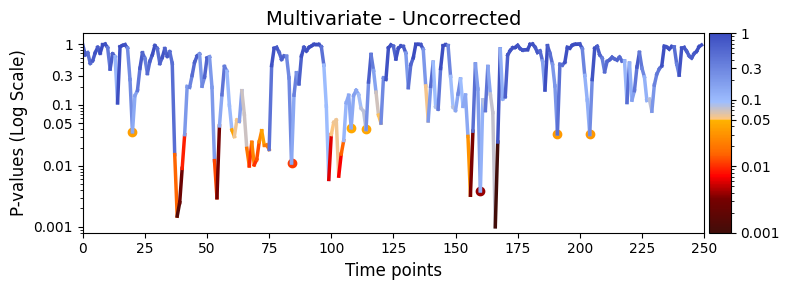

In [12]:
graphics.plot_p_values_over_time(
    result_multivariate_session["pval"],
    title_text="Multivariate - Uncorrected",
    xlabel="Time points",
    num_x_ticks=11
)

### Multiple testing correction
To reduce the chance of false positives, we apply **Benjamini-Hochberg correction** to control the false discovery rate:


**Visualisation of results**\
Now that we have performed our test, we can then visualise the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Benjamini/Hochberg correction.

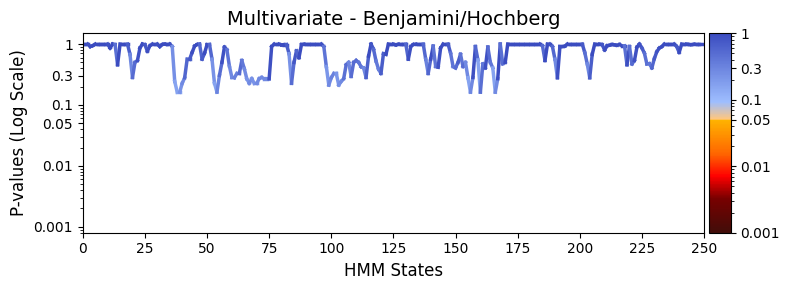

In [13]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivariate_session, 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, 
                                 title_text ="Multivariate - Benjamini/Hochberg", 
                                 xlabel="HMM States", 
                                 num_x_ticks=11)

### Cluster-based correction
To control for family-wise error rate more strictly, we can apply **cluster-based permutation testing**. This is useful when you expect effects to be temporally contiguous.

Make sure `test_statistics_option=True` was set earlier, as this is required to access the full permutation distribution:

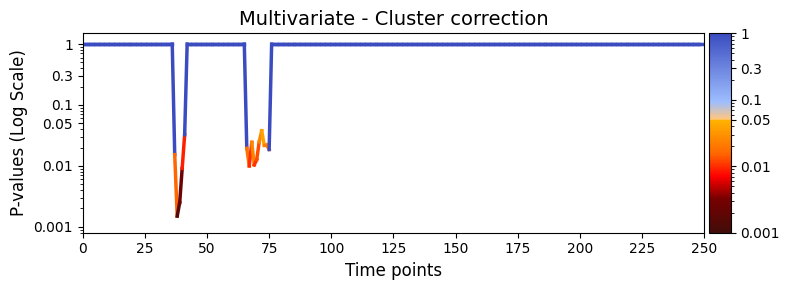

In [14]:
pval_cluster = statistics.pval_cluster_based_correction(result_multivariate_session)

graphics.plot_p_values_over_time(
    pval_cluster,
    title_text="Multivariate - Cluster correction",
    xlabel="Time points",
    num_x_ticks=11
)

## **Across-sessions within subject testing - Univariate test**<a id="perm-correlation"></a>
Now let's look at the **univariate test**, which checks each brain state individually. This allows us to see whether a particular state is linked to the stimulus condition (e.g. animate vs inanimate).

This test runs separately for each state and each timepoint, giving a more detailed view of where effects might occur.

#### Inputs:
- `D_data`: the Gamma matrix reshaped into trials (`Gamma_epoch`)
- `R_data`: stimulus labels (`R_sessions`)
- `indices_blocks`: session boundaries (`idx_sessions`)

#### Settings:
- `method = "univariate"`: run one test per state
- `Nnull_samples = 10_000`: number of permutations



In [ ]:
# Set the parameters for between-subject testing
method = "univariate"
Nnull_samples = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate =statistics.test_across_sessions_within_subject(D_data=Gamma_epoch, 
                                                                  R_data=R_sessions, 
                                                                  indices_blocks=idx_sessions,
                                                                  method=method,
                                                                  Nnull_samples=Nnull_samples)

Total possible permutations: 3.62e+6
Running number of permutations: 1000
performing permutation testing per timepoint


100%|██████████| 250/250 [20:07<00:00,  4.83s/it]


### Visualising univariate results
We can now plot the p-values as a matrix where each row is a state and each column is a timepoint.\
This is done by using the `plot_p_value_matrix` function from the `graphics` module.
> <span style="color:red;">Red</span> areas in the plot indicate timepoints where the result was statistically significant (p < 0.05).

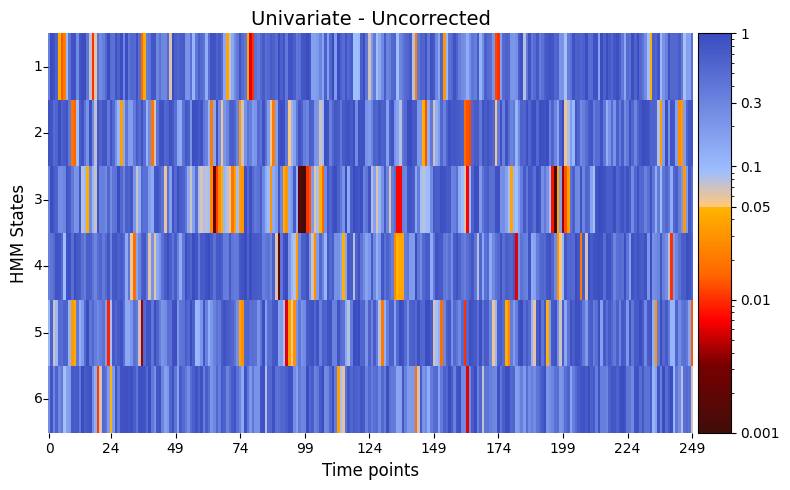

In [29]:
# Plot p-values
# P-values between reaction time and each state as function of time
graphics.plot_p_value_matrix(result_univariate["pval"].T, 
                             title_text ="Univariate - Uncorrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

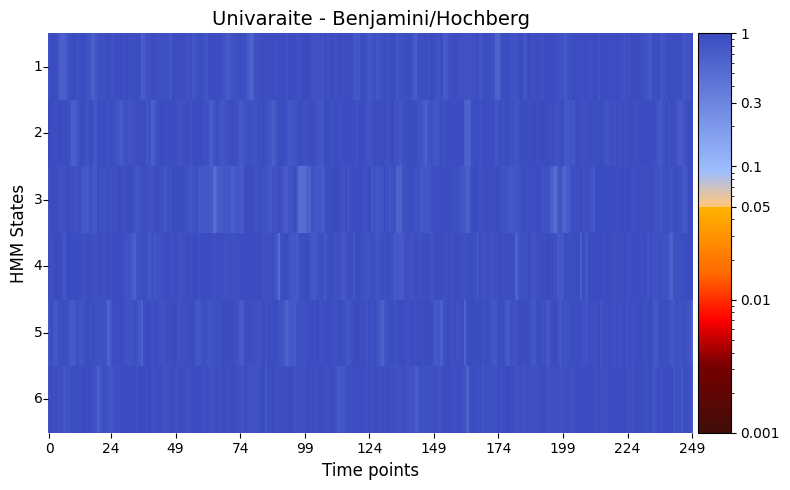

In [30]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate, 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, 
                             title_text ="Univaraite - Benjamini/Hochberg",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

### Cluster-based correction for univariate test
We can also apply cluster-based correction here to account for contiguous significant effects across time:


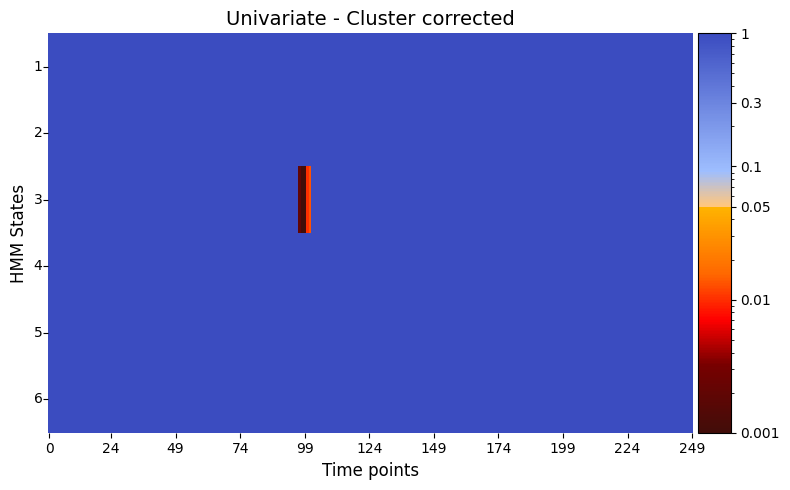

In [31]:
pval_cluster =statistics.pval_cluster_based_correction(result_univariate, individual_feature=True,)
# Plot p-values
graphics.plot_p_value_matrix(pval_cluster.T, 
                             title_text ="Univariate - Cluster corrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Family-Wise Error Rate (FWER) correction**\
We apply FWER correction using the MaxT method, which controls for false positives across multiple comparisons by considering the maximum test statistic across permutations.

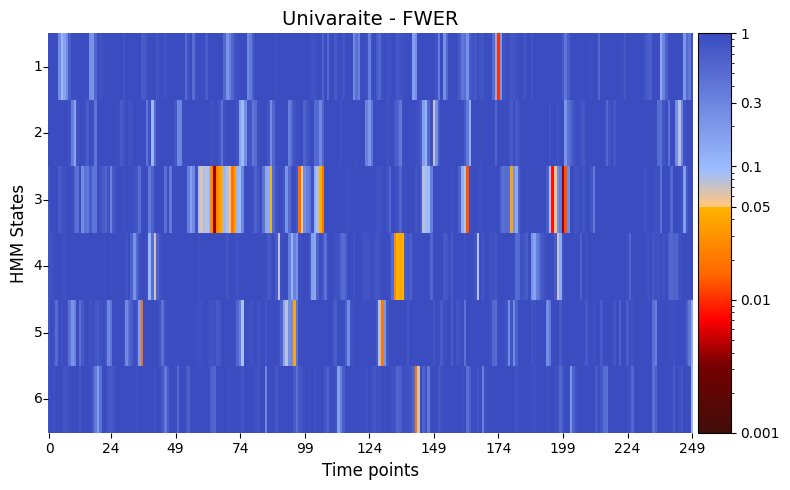

In [32]:
# Correct for FWER
pval_FWER = statistics.pval_FWER_correction(result_univariate)

# Correct p-values using FWER
graphics.plot_p_value_matrix(pval_FWER.T, 
                             title_text ="Univaraite - FWER",figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)